In [1]:
# some early test of lqg on linear RNN
import numpy as np
import sys
from rnn_lin import RNN
import matplotlib.pyplot as plt
import json
import torch
import control

## Loading Trained Weights

In [2]:
with open('MG_lin_32_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'weight_posneg'])

In [4]:
# gains = np.array(weight_history['trained gain'])
# shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weights = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])
weight_posneg = np.array(weight_history['weight_posneg'])
weight_matrix = np.abs(weight_matrix) * weight_posneg

## Defining Network

In [5]:
time_constant = 100 #ms
timestep = 10 #ms
time = 3000 #ms
num_inputs = 1
num_nodes = 32
init_activations = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activations, None, None, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)

In [6]:
# Defining Inputs and Targets
def generate_MackeyGlass(ntimes, tau):
    # initial condition
    # x_values = np.random.uniform(0,1,tau).tolist()
    x_values = [0.1]*tau

    def mackey_glass(x, tau, gamma=0.1, beta0=0.2, n=10):
        dxdt = beta0 * x[-tau] / (1 + x[-tau]**n) - gamma * x[-1]
        return dxdt

    x_t = x_values[-1]
    for t in range(ntimes):
        dxdt = mackey_glass(x_values, tau)
        x_t = x_t + dxdt
        x_values.append(x_t)

    x = x_values[tau:]
    return x

total_time_steps = 300
tau = 20
MG_sequence = np.array(generate_MackeyGlass(total_time_steps+1, tau))
inputs = MG_sequence[0:300].reshape(-1,1)
targets = MG_sequence[1:301].reshape(-1,1)

nt = total_time_steps
time_points = np.arange(nt).reshape(-1, 1)

# define matrices
A = weight_matrix - np.diag(np.ones(num_nodes))
B = np.diag(np.ones(num_nodes))
C = np.diag(np.ones(num_nodes))
G = np.diag(np.ones(num_nodes))
Q = np.diag(np.ones(num_nodes)) * 1
R = np.diag(np.ones(num_nodes)) * 0.01
Qn = np.diag(np.ones(num_nodes)) * 0.1
Rn = np.diag(np.ones(num_nodes)) * 0.1
c = network.timestep/network.time_const

# define noise
x_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=Qn, size=nt)).T
y_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=Rn, size=nt)).T

x_noises[:,100:150] += 1
# x_noises *= 0

In [7]:
# from model
outputs, activations = network.simulate(time, torch.tensor(inputs).float(), input_weights) 

100%|██████████| 300/300 [00:00<00:00, 38347.34it/s]


In [8]:
# manual simulation without feedback, with noise
c = network.timestep/network.time_const
activations_nofb = [init_activations]
outputs_nofb = []
for t in time_points:
    last_acitvation = activations_nofb[-1]
    this_input = inputs[t] * input_weights.T
    this_noise = x_noises[:,t]
    # this_noise = 0
    this_activation = (1 - c) * last_acitvation + c * weight_matrix @ last_acitvation + c * this_input + c * this_noise
    this_output = output_weight_matrix @ this_activation
    activations_nofb.append(this_activation)
    outputs_nofb.append(this_output.item())

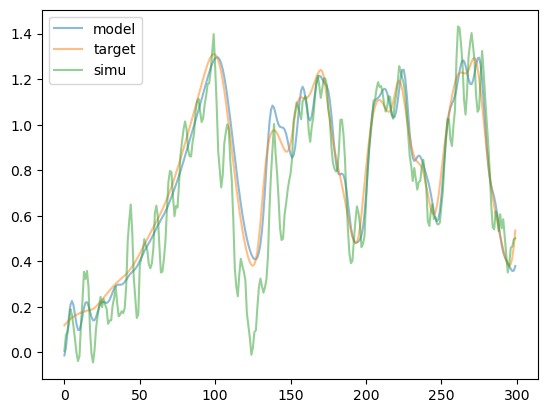

In [9]:
# check manual simulation
fig, ax = plt.subplots()
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.plot(time_points, targets, alpha=0.5, label='target')
plt.plot(time_points, outputs_nofb, alpha=0.5, label='simu')
plt.legend()
plt.show()

## LQR

In [10]:
# controlability matrix
Ctrl = control.ctrb(A,B)
print(Ctrl)
print(np.linalg.matrix_rank(Ctrl))

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ... -8.46400912e+23
  -6.22679380e+22  2.20985952e+22]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ... -1.38315842e+24
  -5.61484461e+22  1.11701277e+23]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ... -6.49025197e+23
  -8.00999472e+22 -3.66746516e+22]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.01658910e+23
  -1.64744749e+23 -3.91718309e+23]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.28451067e+23
  -8.82359704e+22 -1.65254961e+23]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.02240630e+23
  -9.40885185e+22 -1.85878429e+23]]
4


In [11]:
# lqr
K, _, E = control.lqr(A,B,Q,R)
print(K.shape)
K

(32, 32)


array([[ 9.25168702, -0.24323963, -0.16511502, ...,  0.09211735,
        -0.07910409, -0.0583959 ],
       [-0.24323963,  9.40125689, -0.18327798, ...,  0.22974805,
        -0.055789  , -0.07808054],
       [-0.16511502, -0.18327798,  9.0745908 , ...,  0.55364875,
         0.28555168,  0.68000242],
       ...,
       [ 0.09211735,  0.22974805,  0.55364875, ...,  9.81826202,
         0.02436511,  0.0448604 ],
       [-0.07910409, -0.055789  ,  0.28555168, ...,  0.02436511,
         9.04561845,  0.13714622],
       [-0.0583959 , -0.07808054,  0.68000242, ...,  0.0448604 ,
         0.13714622,  9.22036912]])

In [12]:
# manual simulation with feedback
c = network.timestep/network.time_const
activations_fb = [init_activations]
outputs_fb = []
ideal_activations = activations.detach().numpy()

for t in time_points:
    last_acitvation = activations_fb[-1]
    this_input = inputs[t] * input_weights.T
    this_noise = x_noises[:,t]
    # this_noise = 0
    this_ideal_activation = ideal_activations[t,:].T

    this_activation = (1 - c) * last_acitvation + c * weight_matrix @ last_acitvation + c * this_input + c * this_noise + c * B @ (-K @ (last_acitvation - this_ideal_activation))
    this_output = output_weight_matrix @ this_activation
    activations_fb.append(this_activation)
    outputs_fb.append(this_output.item())

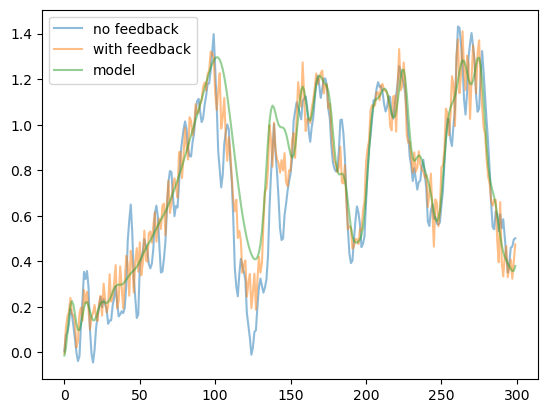

In [13]:
# check feedback
plt.plot(time_points, outputs_nofb, alpha=0.5, label='no feedback')
plt.plot(time_points, outputs_fb, alpha=0.5, label='with feedback')
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.legend()
plt.show()

## Kalman Filter

In [14]:
Obsv = control.obsv(A, C)
np.linalg.matrix_rank(Obsv)

4

In [15]:
L, _, _ = control.lqe(A, G, C, Qn, Rn)
L

array([[ 0.62694595, -0.0233097 ,  0.0193102 , ...,  0.01072194,
         0.00302917,  0.01026369],
       [-0.0233097 ,  0.93731682,  0.08531037, ...,  0.08527861,
         0.00754298,  0.00171255],
       [ 0.0193102 ,  0.08531037,  0.5309566 , ...,  0.06837162,
         0.09186943,  0.13625786],
       ...,
       [ 0.01072194,  0.08527861,  0.06837162, ...,  0.36183922,
         0.02510054, -0.01211802],
       [ 0.00302917,  0.00754298,  0.09186943, ...,  0.02510054,
         0.45857298,  0.02646559],
       [ 0.01026369,  0.00171255,  0.13625786, ..., -0.01211802,
         0.02646559,  0.40172504]])

In [16]:
# manual simulation without feedback
kx_init = np.zeros((num_nodes, 1))
u = np.zeros((num_nodes, 1))
kxs = [kx_init]

activations_nofb = [init_activations]
outputs_nofb = []
ys_nofb = []

for t in time_points:
    # dynamic system
    last_acitvation = activations_nofb[-1]
    this_input = inputs[t] * input_weights.T
    this_noise = x_noises[:,t]
    this_ynoise = y_noises[:,t]

    this_activation = (1 - c) * last_acitvation + c * weight_matrix @ last_acitvation + c * B @ this_input + c * G @ this_noise
    this_output = output_weight_matrix @ this_activation
    this_y = C @ this_activation + this_ynoise

    activations_nofb.append(this_activation)
    outputs_nofb.append(this_output.item())
    ys_nofb.append(this_y)

    # kalman system
    last_kx = kxs[-1]
    theo_this_kx = (1 - c) * last_kx + c * weight_matrix @ last_kx + c * B @ this_input
    # theo_this_y = C @ theo_this_kx
    theo_this_y = C @ last_kx
    this_kx = theo_this_kx + c * L @ (this_y - theo_this_y)
    # this_kx = (1 - c) * last_kx + c * weight_matrix @ last_kx + c * B @ this_input + L @ this_y - L @ (C @ last_kx)
    kxs.append(this_kx)

In [17]:
diffs = [np.sum(np.power(x[0] - x[1],2))/num_nodes for x in zip(activations_nofb, kxs)]
print(np.mean(diffs))

0.023807160151227646


In [18]:
koutputs = [(output_weight_matrix @ x).item() for x in kxs]
# koutputs

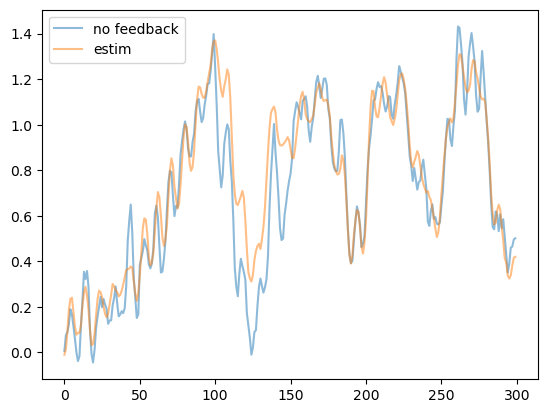

In [19]:
# check feedback
plt.plot(time_points, outputs_nofb, alpha=0.5, label='no feedback')
plt.plot(time_points, koutputs[1:], alpha=0.5, label='estim')
# plt.plot(time_points, outputs_fb, alpha=0.5, label='with feedback')
# plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.legend()
plt.show()

### Combine LQG

In [20]:
# lqr
K, _, _ = control.lqr(A,B,Q,R)
print(K.shape)
K

(32, 32)


array([[ 9.25168702, -0.24323963, -0.16511502, ...,  0.09211735,
        -0.07910409, -0.0583959 ],
       [-0.24323963,  9.40125689, -0.18327798, ...,  0.22974805,
        -0.055789  , -0.07808054],
       [-0.16511502, -0.18327798,  9.0745908 , ...,  0.55364875,
         0.28555168,  0.68000242],
       ...,
       [ 0.09211735,  0.22974805,  0.55364875, ...,  9.81826202,
         0.02436511,  0.0448604 ],
       [-0.07910409, -0.055789  ,  0.28555168, ...,  0.02436511,
         9.04561845,  0.13714622],
       [-0.0583959 , -0.07808054,  0.68000242, ...,  0.0448604 ,
         0.13714622,  9.22036912]])

In [21]:
# Kalman filter
L, _, _ = control.lqe(A, G, C, Qn, Rn)
print(L.shape)
L

(32, 32)


array([[ 0.62694595, -0.0233097 ,  0.0193102 , ...,  0.01072194,
         0.00302917,  0.01026369],
       [-0.0233097 ,  0.93731682,  0.08531037, ...,  0.08527861,
         0.00754298,  0.00171255],
       [ 0.0193102 ,  0.08531037,  0.5309566 , ...,  0.06837162,
         0.09186943,  0.13625786],
       ...,
       [ 0.01072194,  0.08527861,  0.06837162, ...,  0.36183922,
         0.02510054, -0.01211802],
       [ 0.00302917,  0.00754298,  0.09186943, ...,  0.02510054,
         0.45857298,  0.02646559],
       [ 0.01026369,  0.00171255,  0.13625786, ..., -0.01211802,
         0.02646559,  0.40172504]])

In [22]:
# manual simulation with kalman and lqr
activations_lqg = [init_activations]
activations_hat = [init_activations]
ideal_activations = activations.detach().numpy()
outputs_lqg = []

for t in np.arange(nt):

    # lqr
    last_acitvation_hat = activations_hat[-1]
    # last_acitvation_hat = activations_lqg[-1] # test without kalman
    this_ideal_activation = ideal_activations[t,:].reshape(-1,1)
    this_u = -K @ (last_acitvation_hat - this_ideal_activation)
    # this_u = np.ones((num_nodes,1)) # test without lqr

    # dynamic system
    last_acitvation = activations_lqg[-1]
    this_input = inputs[t] * input_weights.T
    this_xnoise = x_noises[:,t].reshape(-1,1)
    this_ynoise = y_noises[:,t].reshape(-1,1)
    
    this_activation = (1 - c) * last_acitvation + c * weight_matrix @ last_acitvation + c * B @ this_input + c * B @ this_u + c * G @ this_xnoise
    this_output = output_weight_matrix @ this_activation
    this_y = C @ this_activation + this_ynoise
    
    activations_lqg.append(this_activation)
    outputs_lqg.append(this_output.item())

    # Kalman system
    theo_this_kx = (1 - c) * last_acitvation_hat + c * weight_matrix @ last_acitvation_hat + c * B @ this_input + c * B @ this_u
    # theo_this_kx = (1 - c) * last_acitvation_hat + c * weight_matrix @ last_acitvation_hat + c * B @ this_input
    theo_this_y = C @ theo_this_kx
    # theo_this_y = C @ last_acitvation_hat
    this_acitvation_hat = theo_this_kx + c * L @ (this_y - theo_this_y)
    activations_hat.append(this_acitvation_hat)

    # print(np.mean(np.abs(this_acitvation_hat - this_activation)))

In [23]:
diffs = [np.sum(np.power(x[0] - x[1],2))/num_nodes for x in zip(activations_lqg, activations_hat)]
print(np.mean(diffs))

0.013268612525263946


In [24]:
tt = []
df = []
for i in range(len(ideal_activations)):
    p = activations_hat[i+1] - ideal_activations[i,:].reshape(-1,1)
    tmp = output_weight_matrix @ p
    tmp = tmp.item()

    tt.append(tmp)
    df.append(np.mean(np.power(p,2)))
print(np.mean(df))

0.009091723831065442


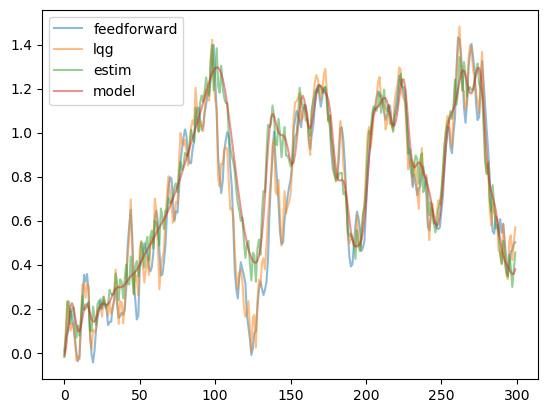

In [25]:
# check feedback
plt.plot(time_points, outputs_nofb, alpha=0.5, label='feedforward')
plt.plot(time_points, outputs_lqg, alpha=0.5, label='lqg')
kkoutputs = [(output_weight_matrix @ x).item() for x in activations_hat]
plt.plot(time_points, kkoutputs[1:], alpha=0.5, label='estim')
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.legend()
plt.show()